In [1]:
import pandas as pd
accept = pd.read_csv('../rawData/accepted_2007_to_2018Q4.csv')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
# These columns all have mixed datatypes
accept.columns[[0,19,49,59,118,129,130,131,134,135,136,139,145,146,147]]

Index(['id', 'desc', 'next_pymnt_d', 'verification_status_joint',
       'sec_app_earliest_cr_line', 'hardship_type', 'hardship_reason',
       'hardship_status', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_loan_status',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

In [3]:
# id is worth fixing
def find_weird(x):
    try:
        _ = int(x)
        return(True)
    except:
        return(False)

accept = accept[accept['id'].apply(find_weird)]
accept['id'] = accept['id'].apply(int)
accept['id'].dtype

dtype('int64')

In [4]:
# Let's look at a couple of entries
pd.options.display.max_rows = 155
accept.sample(2).T

,1278483,1111908
id,14137782,68388819
member_id,NaN,NaN
loan_amnt,7200,25000
funded_amnt,7200,25000
funded_amnt_inv,7200,25000
term,36 months,60 months
int_rate,18.24,14.85
installment,261.17,592.79
grade,D,C
sub_grade,D5,C5


In [5]:
# What's the status with missingness?
accept.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2260668 entries, 0 to 2260698
Data columns (total 151 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          2260668 non-null  int64  
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   2260668 non-null  float64
 3   funded_amnt                                 2260668 non-null  float64
 4   funded_amnt_inv                             2260668 non-null  float64
 5   term                                        2260668 non-null  object 
 6   int_rate                                    2260668 non-null  float64
 7   installment                                 2260668 non-null  float64
 8   grade                                       2260668 non-null  object 
 9   sub_grade                                   2260668 non-

In [19]:
# Let's look at the distribution of the target variable
status = accept['loan_status'].value_counts()
print(status)
bad = status[2] + status[-2] + status[-1]
print()
print(f'Charged off and defaulted: {bad / sum(status):.1%} of all loans')

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

Charged off and defaulted: 11.9% of all loans


In [7]:
# Aiko's Question 1
# Variation in annual issuance
# Step 1: convert issue_d to datetime
import datetime as dt
def make_dateval(s):
    s = s.split('-')
    return(dt.datetime.strptime(s[1] + s[0] + '01', '%Y%b%d'))
    
accept['issue_d'] = accept['issue_d'].apply(make_dateval)

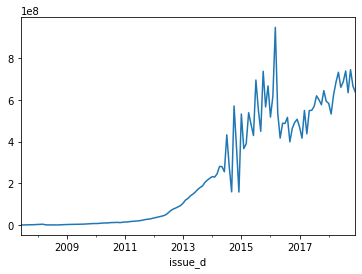

In [25]:
monthly_issue = accept.groupby('issue_d')['funded_amnt'].sum()
import matplotlib.pyplot as plt
monthly_issue.plot()
# May 2016 was when the CEO was ousted
# https://www.reuters.com/article/us-lendingclub-results/lending-club-ceo-resigns-after-internal-probe-shares-plummet-idUSKCN0Y01BK#:~:text=(Reuters%2FIFR)%20%2D%20Renaud,the%20company%20said%20on%20Monday.

In [9]:
accept['purpose'].value_counts()

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
house                   14136
wedding                  2355
renewable_energy         1445
educational               424
Name: purpose, dtype: int64

In [44]:
# Show distribution of ratings for different purposes
rating_by_purpose = accept.groupby(['purpose', 'sub_grade'])['id'].count()  # or use grade for less graularity
rating_by_purpose = rating_by_purpose.unstack().T
rating_by_purpose = rating_by_purpose / rating_by_purpose.sum()
import plotly.express as px
fig1 = px.line(rating_by_purpose)
fig1.update_layout(title='Distribution of LC Rating by Purpose',
                   xaxis_title='Rating',
                   yaxis_title='Frequency',
                   yaxis_tickformat = ',.0%')
fig1.show()
# educational and credit cards (the biggest segment) are higher rated; 
# small business, moving and vacation are at the lower end

In [50]:
accept['year'] = accept['issue_d'].apply(lambda x: x.year)

In [51]:
# Show distribution of ratings for different years
rating_by_year = accept.groupby(['year', 'sub_grade'])['id'].count()  # or use sub_grade for less graularity
rating_by_year = rating_by_year.unstack().T
rating_by_year = rating_by_year / rating_by_year.sum()
import plotly.express as px
fig2 = px.line(rating_by_year)
fig2.update_layout(title='Distribution of LC Rating by year',
                   xaxis_title='Rating',
                   yaxis_title='Frequency',
                   yaxis_tickformat = ',.0%')
fig2.show()
# 2007 is a bit of an outlier